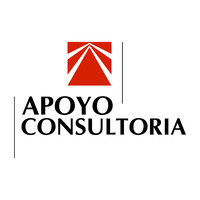

# ARIMA

Esta libreria construye la estimacion de los modelos ARIMA usando la metodologia especificada en el punto 2.1 del informe, mediante la metodología Box Jenkins.

Esta libreria realiza la estimacion, la proyeccion y la evaluación.


# Proyecciones ARIMA

# Librerias

In [1]:
#Importar librerias
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import matplotlib.pyplot as plt

from ipynb.fs.defs.ConstruccionBasedeDatos import BasedeDatos

In [2]:
rutaOrigen = 'inputs/'
rutaDestino = 'resultados/'
rutaModelos = 'model_nowcast/'


### Construccion de Base de datos

In [3]:
bd_mensual_t,bd_trimestral_t,bd_anual_t,bd_all = BasedeDatos(rutaOrigen + 'bd_Panama.xlsx')

C:\Users\Usuario\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Usuario\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Estimacion y evaluacion de las proyecciones ARIMA

In [4]:
#Funcion de seleccion de mejor modelo, estimacion y proyeccion out sample

def nowcast_arima(serie,train_size,out=1):
    # Se dividen los datos en 2 submuestras: "train" y "test"
    bd_train = serie[:train_size]
    bd_test =  serie[train_size+1:]
    
    # Se define un modelo base ARIMA(3,0,3)
    model = ARIMA(bd_train, order=(3,0,3))
    model_fit = model.fit([0]*7,disp = 0)
   
    # Se definen modelos alternativos ARIMA(i,0,j), donde para i y j se iteran los valores 0,1,2.
    for i in range(4):
        for j in range(4):
            model_aux = ARIMA(serie.dropna(), order=(i,0,j))
            model_fit_aux = model_aux.fit([0]*(i+j+1),disp=0)
            # Se comparan el modelo base contra los modelos alternativos. Se selecciona el mejor modelo.
            if (model_fit_aux.bic < model_fit.bic) & (sum(sm.tsa.stattools.acf(model_fit_aux.resid.dropna(), qstat = True, nlags= 4)[2] < 0.1) == 0):
                model = model_aux
                model_fit = model_fit_aux
   
    # Se estiman predicciones
    predict = model_fit.predict(start = train_size-1, end = train_size + out)

    
    return predict

def eval_arima(serie):
    
    #Base de proyecciones
    prj_pib = pd.DataFrame()

    for train_size in range(30,len(serie)):

        prj_pib = pd.concat([prj_pib,nowcast_arima(serie,train_size)[1:2]], axis = 0)
        
    prj_pib = pd.concat([prj_pib,serie],axis=1)
    
    prj_pib.columns = ['EVAL_ARIMA','PIB_A']
    
    return prj_pib

################################################################


## Proyecciones ARIMA

C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


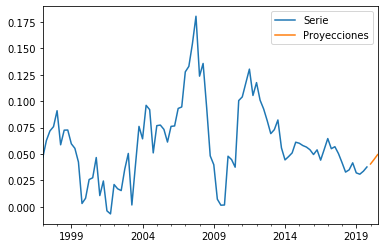

In [5]:
serie = bd_trimestral_t['pbif_Trimestre_VariacionAnual'].dropna()

serie.index = pd.DatetimeIndex(serie.index.values,
                               freq=serie.index.inferred_freq)

baseARIMA = pd.DataFrame()

#Base de proyecciones


baseARIMA.loc[:,'Serie'] = serie 
baseARIMA = baseARIMA.join(pd.DataFrame(nowcast_arima(serie,len(serie)+1),columns = ['Proyecciones']),how = 'outer')

baseARIMA.plot()
    
plt.show()

In [6]:
with pd.ExcelWriter(rutaDestino + 'baseARIMA.xlsx') as writer:
    baseARIMA.to_excel(writer, sheet_name='Proyecciones ARIMA')

## Evaluacion de Proyecciones

In [7]:
eval_arima = eval_arima(serie)

C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


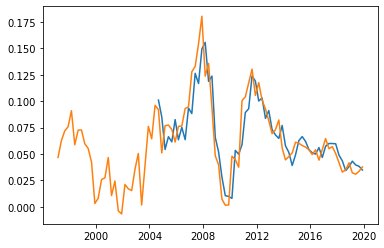

In [8]:
plt.plot(eval_arima)